In [1]:
import torch
import os
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import json
import seaborn as sns
from PIL import Image
import copy
from collections import OrderedDict
from torch.optim import lr_scheduler
from torch.autograd import Variable
import operator

starttime = time.time()


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU.....Left, Square, Square, Square, Left ')
    
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

CUDA is available!  Training on GPU.....Left, Square, Square, Square, Left 
Time Stage: 0.090 seconds


break

In [2]:
def plotda_training(train_losses, valid_losses):
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('epochs')
    plt.legend(frameon=False)
    plt.title('Loss progress')
    plt.show()
    plt.savefig('progress.png')

In [3]:
# define training and test data directories
data_dir = 'C:/PyTorch/flower_data/'
#data_dir = 'C:/PyTorch/flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

In [4]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 30
num_workers= 8

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Num training images:  6553
Num valid images:  832
Num test images:  817
Time Stage: 0.237 seconds


In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
class_names = train_data.classes

sortedclasses = sorted(cat_to_name.items())
print(sortedclasses[0])



('1', 'pink primrose')


### Visualize a Batch of Training Data

In [6]:
# helper function to un-normalize and display an image
def imshow(img):

    img = img.transpose(1,2,0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)

    plt.imshow(img)  # convert from Tensor image

Time Stage: 4.272 seconds


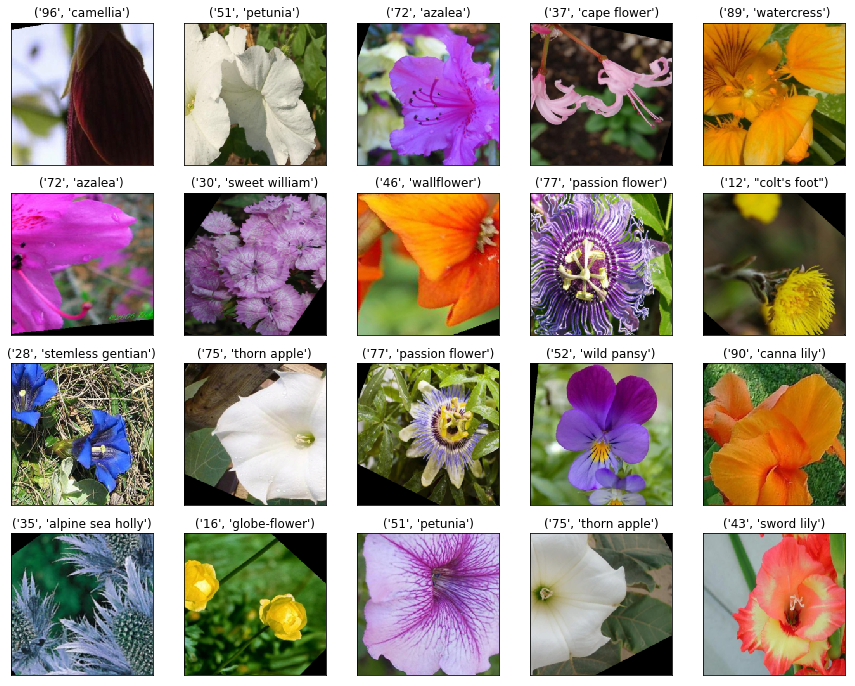

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 12))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(sortedclasses[labels[idx]])
    
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")    

In [8]:
print(f"Time Stage Start: {(starttime):.3f} seconds")
# Load the pretrained model from pytorch
model = models.densenet121(pretrained=True)
#print(model)

# Freeze training for all "features" layers
for param in model.parameters():
    param.requires_grad = False
    
    
n_inputs = model.classifier.in_features
print(model.classifier.in_features) 
print(model.classifier.out_features) 

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 850)),
                          ('relu', nn.ReLU()),
                          ('dr', nn.Dropout(0.35)),                        
                          ('fc2', nn.Linear(850, len(cat_to_name))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier


# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

criterion = nn.NLLLoss()
    

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.0006, betas=(0.9, 0.999), eps=1e-08, 
                       weight_decay=1e-05, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.10, patience=4, 
                                                 verbose=False, threshold=0.0001, threshold_mode='rel', 
                                                 cooldown=2, min_lr=0, eps=1e-08)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 1546670163.000 seconds


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming

1024
1000
Time Stage: 6.996 seconds


In [9]:
print(f"Time Stage Start: {(starttime):.3f} seconds")
# number of epochs to train the model
n_epochs = 12

valid_loss_min = np.Inf # track change in validation loss

train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    start = time.time()
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    #    if batch_idx % 20 == 19:    # print training loss every specified number of mini-batches
     #       print('\t Epoch %d, Batch %d loss: %.16f' %
      #            (epoch, batch_idx + 1, train_loss / 20))
       #     print(f"\t \tTime per batch: {(time.time() - start)/3:.3f} seconds")
        #    train_loss = 0.0
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model.state_dict(), 'model_augmented.pt')
        model.class_to_idx = train_data.class_to_idx
        #model.cpu()
        torch.save({'state_dict': model.state_dict(), 
                    'class_to_idx': model.class_to_idx}, 
                    'Project_ThumperRevJv1.pth')
        valid_loss_min = valid_loss
    
    print(f"Time per epoch: {(time.time() - start):.3f} seconds")
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 1546670163.000 seconds
Epoch: 1 	Training Loss: 3.201262 	Validation Loss: 1.507446
Validation loss decreased (inf --> 1.507446).  Saving model ...
Time per epoch: 25.815 seconds
Epoch: 2 	Training Loss: 1.503546 	Validation Loss: 0.742438
Validation loss decreased (1.507446 --> 0.742438).  Saving model ...
Time per epoch: 24.590 seconds
Epoch: 3 	Training Loss: 1.020892 	Validation Loss: 0.491328
Validation loss decreased (0.742438 --> 0.491328).  Saving model ...
Time per epoch: 24.617 seconds
Epoch: 4 	Training Loss: 0.864112 	Validation Loss: 0.428018
Validation loss decreased (0.491328 --> 0.428018).  Saving model ...
Time per epoch: 24.487 seconds
Epoch: 5 	Training Loss: 0.760020 	Validation Loss: 0.327283
Validation loss decreased (0.428018 --> 0.327283).  Saving model ...
Time per epoch: 24.587 seconds
Epoch: 6 	Training Loss: 0.684076 	Validation Loss: 0.318398
Validation loss decreased (0.327283 --> 0.318398).  Saving model ...
Time per epoch: 24.464 second

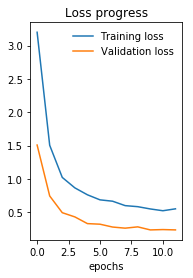

<Figure size 432x288 with 0 Axes>

In [10]:
plotda_training(train_losses,valid_losses)

In [11]:
print(f"Time Stage Start: {(starttime):.3f} seconds")
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    #for i in range(20):
    for i in range (len(target.data)): 
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(102):
   if class_total[i] > 0:
       print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           sortedclasses[i], 100 * class_correct[i] / class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
   else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
   100. * np.sum(class_correct) / np.sum(class_total),
   np.sum(class_correct), np.sum(class_total)))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 1546670163.000 seconds
Test Loss: 0.217118

Test Accuracy of ('1', 'pink primrose'): 100% ( 5/ 5)
Test Accuracy of ('10', 'globe thistle'): 100% ( 3/ 3)
Test Accuracy of ('100', 'blanket flower'): 100% ( 8/ 8)
Test Accuracy of ('101', 'trumpet creeper'): 100% ( 4/ 4)
Test Accuracy of ('102', 'blackberry lily'): 100% ( 6/ 6)
Test Accuracy of ('11', 'snapdragon'): 66% ( 6/ 9)
Test Accuracy of ('12', "colt's foot"): 88% ( 8/ 9)
Test Accuracy of ('13', 'king protea'): 100% ( 6/ 6)
Test Accuracy of ('14', 'spear thistle'): 100% ( 3/ 3)
Test Accuracy of ('15', 'yellow iris'): 100% ( 4/ 4)
Test Accuracy of ('16', 'globe-flower'): 100% ( 3/ 3)
Test Accuracy of ('17', 'purple coneflower'): 100% ( 9/ 9)
Test Accuracy of ('18', 'peruvian lily'): 100% ( 6/ 6)
Test Accuracy of ('19', 'balloon flower'): 100% ( 7/ 7)
Test Accuracy of ('2', 'hard-leaved pocket orchid'): 100% ( 5/ 5)
Test Accuracy of ('20', 'giant white arum lily'): 100% ( 3/ 3)
Test Accuracy of ('21', 'fire lily'): 1

Time Stage Start: 1546670163.000 seconds
Time Stage: 315.329 seconds


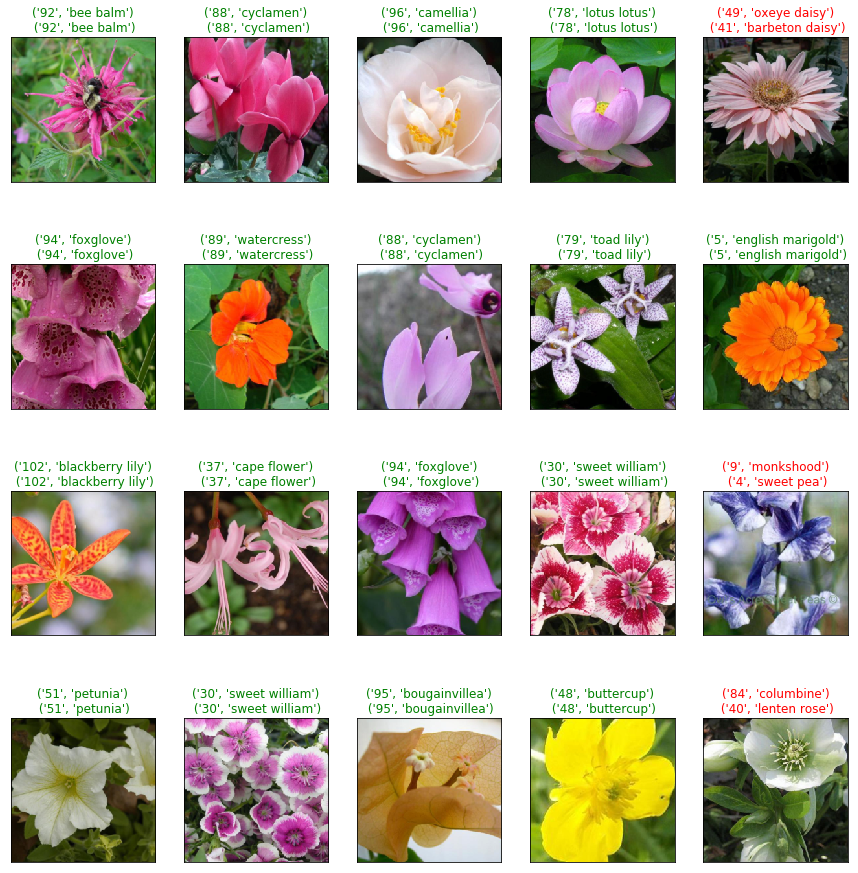

In [12]:
print(f"Time Stage Start: {(starttime):.3f} seconds")
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 16))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    imshow(images[idx])
    ax.set_title("{}\n {}".format(sortedclasses[preds[idx]], sortedclasses[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
print(f"Time Stage Start: {(starttime):.3f} seconds")
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model


model = load_checkpoint('Project_ThumperRevJv1.pth')

for param in model.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam(model.parameters(), lr=0.00008, betas=(0.9, 0.999), eps=1e-08, 
                       weight_decay=1e-04, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.10, patience=4, 
                                                 verbose=False, threshold=0.0001, threshold_mode='rel', 
                                                 cooldown=2, min_lr=0, eps=1e-08)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 1546670163.000 seconds
Time Stage: 316.282 seconds


In [14]:
print(f"Time Stage Start: {(starttime):.3f} seconds")
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss
train_losses2 = []
valid_losses2 = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    start = time.time()
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    #    if batch_idx % 20 == 19:    # print training loss every specified number of mini-batches
     #       print('\t Epoch %d, Batch %d loss: %.16f' %
      #            (epoch, batch_idx + 1, train_loss / 20))
       #     print(f"\t \tTime per batch: {(time.time() - start)/3:.3f} seconds")
        #    train_loss = 0.0
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses2.append(train_loss)
    valid_losses2.append(valid_loss)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model.state_dict(), 'model_augmented.pt')
        model.class_to_idx = train_data.class_to_idx
        #model.cpu()
        torch.save({'state_dict': model.state_dict(), 
                    'class_to_idx': model.class_to_idx}, 
                    'Project_ThumperRevJv1True.pth')
        valid_loss_min = valid_loss
    
    print(f"Time per epoch: {(time.time() - start):.3f} seconds")
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 1546670163.000 seconds
Epoch: 1 	Training Loss: 0.405958 	Validation Loss: 0.160447
Validation loss decreased (inf --> 0.160447).  Saving model ...
Time per epoch: 67.012 seconds
Epoch: 2 	Training Loss: 0.289815 	Validation Loss: 0.123907
Validation loss decreased (0.160447 --> 0.123907).  Saving model ...
Time per epoch: 66.237 seconds
Epoch: 3 	Training Loss: 0.262735 	Validation Loss: 0.104052
Validation loss decreased (0.123907 --> 0.104052).  Saving model ...
Time per epoch: 66.908 seconds
Epoch: 4 	Training Loss: 0.235463 	Validation Loss: 0.109917
Time per epoch: 67.062 seconds
Epoch: 5 	Training Loss: 0.197396 	Validation Loss: 0.116546
Time per epoch: 65.627 seconds
Epoch: 6 	Training Loss: 0.190987 	Validation Loss: 0.111830
Time per epoch: 65.467 seconds
Epoch: 7 	Training Loss: 0.184804 	Validation Loss: 0.097647
Validation loss decreased (0.104052 --> 0.097647).  Saving model ...
Time per epoch: 65.651 seconds
Epoch: 8 	Training Loss: 0.162198 	Validatio

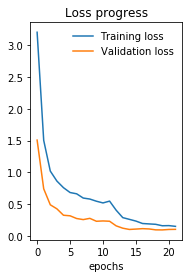

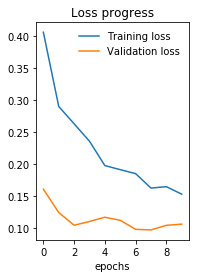

<Figure size 432x288 with 0 Axes>

In [15]:
plotda_training(train_losses,valid_losses)
plotda_training(train_losses2,valid_losses2)

In [16]:
print(f"Time Stage Start: {(starttime):.3f} seconds")
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    #for i in range(20):
    for i in range (len(target.data)): 
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(102):
   if class_total[i] > 0:
       print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           sortedclasses[i], 100 * class_correct[i] / class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
   else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
   100. * np.sum(class_correct) / np.sum(class_total),
   np.sum(class_correct), np.sum(class_total)))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")



Time Stage Start: 1546670163.000 seconds
Test Loss: 0.064890

Test Accuracy of ('1', 'pink primrose'): 100% ( 5/ 5)
Test Accuracy of ('10', 'globe thistle'): 100% ( 3/ 3)
Test Accuracy of ('100', 'blanket flower'): 100% ( 8/ 8)
Test Accuracy of ('101', 'trumpet creeper'): 100% ( 4/ 4)
Test Accuracy of ('102', 'blackberry lily'): 100% ( 6/ 6)
Test Accuracy of ('11', 'snapdragon'): 88% ( 8/ 9)
Test Accuracy of ('12', "colt's foot"): 100% ( 9/ 9)
Test Accuracy of ('13', 'king protea'): 100% ( 6/ 6)
Test Accuracy of ('14', 'spear thistle'): 100% ( 3/ 3)
Test Accuracy of ('15', 'yellow iris'): 100% ( 4/ 4)
Test Accuracy of ('16', 'globe-flower'): 100% ( 3/ 3)
Test Accuracy of ('17', 'purple coneflower'): 100% ( 9/ 9)
Test Accuracy of ('18', 'peruvian lily'): 83% ( 5/ 6)
Test Accuracy of ('19', 'balloon flower'): 100% ( 7/ 7)
Test Accuracy of ('2', 'hard-leaved pocket orchid'): 100% ( 5/ 5)
Test Accuracy of ('20', 'giant white arum lily'): 100% ( 3/ 3)
Test Accuracy of ('21', 'fire lily'): 1

Time Stage Start: 1546670163.000 seconds
Time Stage: 987.806 seconds


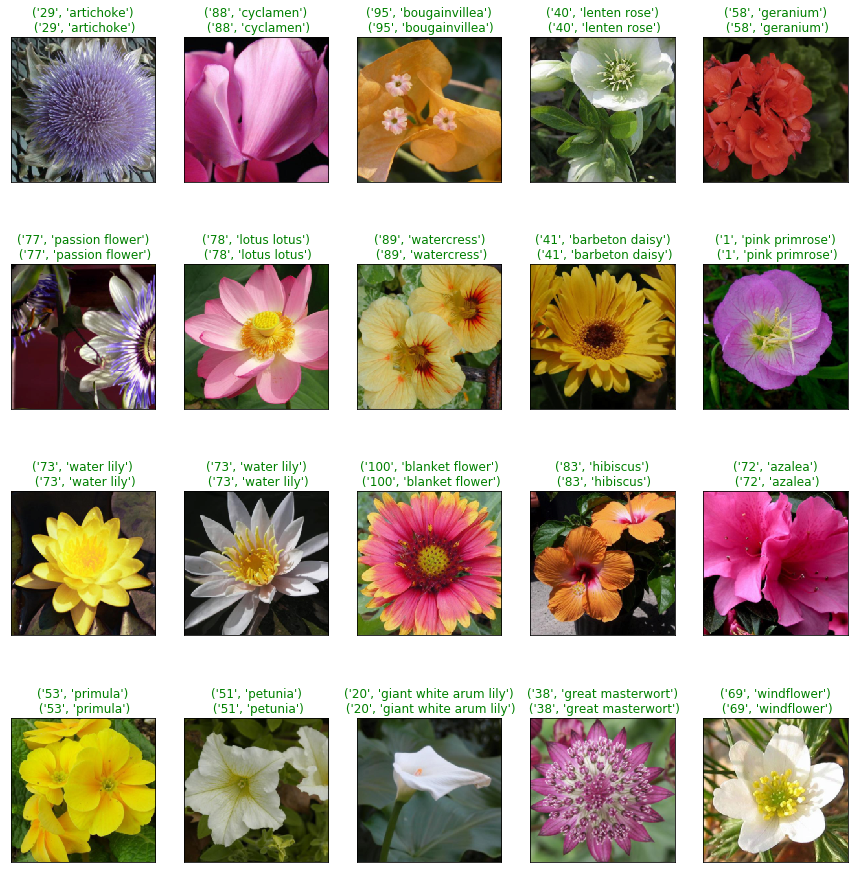

In [17]:
print(f"Time Stage Start: {(starttime):.3f} seconds")
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 16))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    imshow(images[idx])
    ax.set_title("{}\n {}".format(sortedclasses[preds[idx]], sortedclasses[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

In [18]:
image_pathtet = os.path.join(data_dir, 'valid/34/image_06964.jpg')
#imgtet = Image.open(image_pathtet)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage: 988.512 seconds


In [19]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    img = Image.open(image_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((5000, 256))
    else:
        img.thumbnail((256, 5000))

    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #Required mean
    std = np.array([0.229, 0.224, 0.225]) #Required std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    #img = img.numpy().transpose((2, 0, 1))
    img = img.transpose((2, 0, 1))
    
    return img


In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

Time Stage: 988.560 seconds


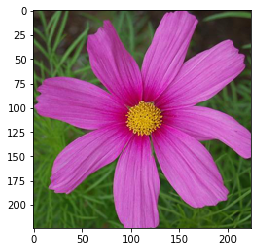

In [21]:
process_image(image_pathtet)
imshow(process_image(image_pathtet))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

In [22]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
        # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)

    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(topk)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}

    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]

    return top_probs, top_labels, top_flowers

In [23]:
probs, classes, flowers = predict(image_pathtet, model.cpu())
print(probs)
print(classes)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

[0.9815822243690491, 0.013018219731748104, 0.004218550864607096, 0.0003074083069805056, 0.00019957975018769503]
['34', '66', '17', '93', '78']
Time Stage: 989.231 seconds


In [24]:
# TODO: Display an image along with the top 5 classes
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    flower_num = image_path.split('/')[4]
    flowerClass = cat_to_name[flower_num]
    #print(flower_num)
    #print(flowerClass)
    # Plot flower
    img = process_image(image_path)
    #imshow(img, ax, title = title_);
    imshow(img, ax);
    #ax.set_title(flowerClass, color=("green"))
    ax.set_title("{}-{}".format(flower_num, flowerClass), color=("green"))

    # Make prediction
    probs, labs, flowers = predict(image_path, model) 

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

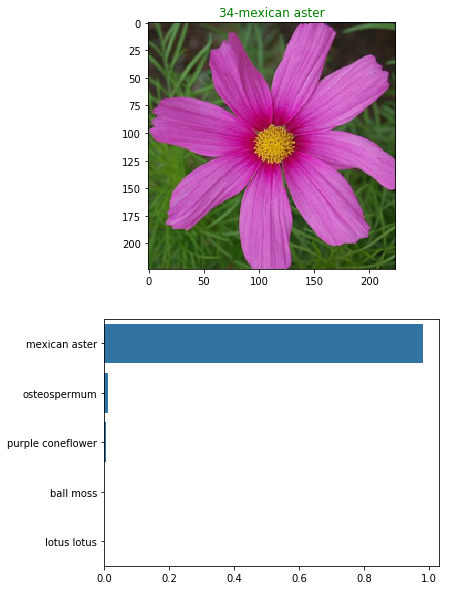

Time Stage: 989.861 seconds


In [25]:
plot_solution(image_pathtet, model)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")